In [1]:
import contextlib

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
@contextlib.contextmanager
def add_subplots(rows: int, cols: int, figsize: tuple[int] = (8, 6)):
    _, axes = plt.subplots(rows, cols, figsize=figsize)
    yield axes

In [4]:
hse_df = pd.read_json("parsed_results/hse_data.json", orient="records")
itmo_df = pd.read_json("parsed_results/itmo_data.json", orient="records")

In [5]:
hse_df.head(n=1)

,title,educational_programme,year,abstract,level,faculty
0,Разработка программы управленческих действий п...,Управление образованием,2016,\n\tТема исследования: Разработка программы уп...,(Магистратура),Институт образования


In [6]:
itmo_df.head(n=1)

,title,educational_programme,year,abstract,level,faculty
0,РАЗРАБОТКА МЕТОДА УДАЛЕНИЯ ОШИБОК ИЗ НАБОРА ЧТ...,010500 Прикладная математика и информатика,2011,Введение. Многие современные задачи биологии и...,бакалавр,Факультет информационных технологий и программ...


## clear data

In [7]:
def has_no_numbers(text: str) -> bool:
    return not any(char.isdigit() for char in text)

assert has_no_numbers("hello!!!")
assert not has_no_numbers("123")
assert not has_no_numbers("HELLO 123")
assert has_no_numbers("")

In [8]:
def take_text_titles(df: pd.DataFrame) -> pd.DataFrame:
    return df.loc[df["title"].map(has_no_numbers)]

In [9]:
for df in [hse_df, itmo_df]:
    print(f"before filter: {len(df)}, after filter: {len(take_text_titles(df))}")

before filter: 47221, after filter: 44538
before filter: 1561, after filter: 1458


In [10]:
def remove_numbers(text: str) -> str:
    return "".join(filter(lambda char: not char.isdigit(), text))

assert remove_numbers("hello") == "hello"
assert remove_numbers("1231923") == ""
assert remove_numbers("hello 123") == "hello "
assert remove_numbers("") == ""

In [11]:
def apply_to_column(df: pd.DataFrame, function, column: str) -> pd.DataFrame:
    df_copy = df.copy()
    df_copy[column] = df_copy[column].map(function)
    return df_copy

In [12]:
for df in [hse_df, itmo_df]:
    transformed_df = apply_to_column(df, remove_numbers, column="educational_programme")
    changed_num = (df["educational_programme"] != transformed_df["educational_programme"]).sum()
    print(f"Changed {changed_num}")

Changed 0
Changed 1560


In [13]:
def unify_level(level: str) -> str:
    if "бакалавр" in level.lower():
        return "bachelor"
    elif "магистр" in level.lower():
        return "master"
    else:
        return "unknown"
    
assert unify_level("(БаКаЛаВрИаТ)") == "bachelor"
assert unify_level("Магистр") == "master"
assert unify_level("Йожик") == "unknown"

In [14]:
for df in [hse_df, itmo_df]:
    transformed_df = apply_to_column(df, unify_level, column="level")
    print(transformed_df["level"].value_counts())

bachelor    28932
master      17711
unknown       578
Name: level, dtype: int64
master      784
bachelor    507
unknown     270
Name: level, dtype: int64


In [15]:
def take_known_levels(df: pd.DataFrame):
    return df.loc[df["level"].isin(["bachelor", "master"])]

In [16]:
def remove_punctuation(text: str, whitelisted_symbols=(" ",)) -> str:
    return "".join(filter(lambda char: char.isalpha() or char in whitelisted_symbols, text))

assert remove_punctuation("hello!!!") == "hello"
assert remove_punctuation("hello, mister freeman", whitelisted_symbols=(" ", ",")) == "hello, mister freeman"
assert remove_punctuation("1*&@!#80123890") == ""

In [17]:
def extract_itmo_faculty(text: str) -> str:
    if "," not in text:
        return text
    
    faculty_parts = [part for part in text.split(",") if "факультет" in part.lower()]
    if len(faculty_parts) > 0 and faculty_parts[0].strip():
        return faculty_parts[0].strip()
    
    return text

assert extract_itmo_faculty("Факультет точной механики и технологии, кафедра измерительных технологий и компьютерной томографии") == \
    "Факультет точной механики и технологии"
assert extract_itmo_faculty("Естественно-научный факультет, кафедра высшей математики") == \
    "Естественно-научный факультет"
assert extract_itmo_faculty("Инженерно-физический факультет, кафедра лазерных технологий и экологического приборостроения") == \
    "Инженерно-физический факультет"

In [18]:
def final_transform(df: pd.DataFrame) -> pd.DataFrame:
    df = take_text_titles(df)
    df = apply_to_column(df, remove_numbers, column="educational_programme")
    df = apply_to_column(df, unify_level, column="level")
    df = apply_to_column(df, remove_punctuation, column="educational_programme")
    df = apply_to_column(df, lambda text: text.strip(), column="educational_programme")
    df = apply_to_column(df, extract_itmo_faculty, column="faculty")
    df = take_known_levels(df)

    return df

In [19]:
transformed_hse_df = final_transform(hse_df)
transformed_itmo_df = final_transform(itmo_df)

print(f"HSE: {len(transformed_hse_df)} rows")
print(f"ITMO: {len(transformed_itmo_df)}")

HSE: 43981 rows
ITMO: 1212


In [20]:
transformed_hse_df.head()

,title,educational_programme,year,abstract,level,faculty
0,Разработка программы управленческих действий п...,Управление образованием,2016,\n\tТема исследования: Разработка программы уп...,master,Институт образования
2,Факторы экономического успеха зарубежных кинок...,Экономика,2016,\n\tВ данной исследовательской работе проводит...,bachelor,Факультет экономических наук
3,Юго-Восточная Азия в политике безопасности США...,Международные отношения европейские и азиатски...,2016,\n\tВ работе анализируются роль и место Юго-Во...,master,Факультет мировой экономики и мировой политики
4,Интернет-мем как арт-объект: художественная сп...,Мультимедийная журналистика,2016,\n\tВ данной магистерской диссертации рассматр...,master,Факультет коммуникаций
5,Влияние разных типов авторитарных режимов на з...,Политология,2016,\n\tВлияние различных типов авторитарных режим...,bachelor,Факультет социальных наук


## plot distributions

In [20]:
def rename_title(name: str):
    if name == "title":
        return "count"
    return name

In [21]:
def plot_year_distriubtion(df: pd.DataFrame, title: str, ax):
    sns.countplot(x="year", data=df, ax=ax, color="b")
    ax.set_title(title)

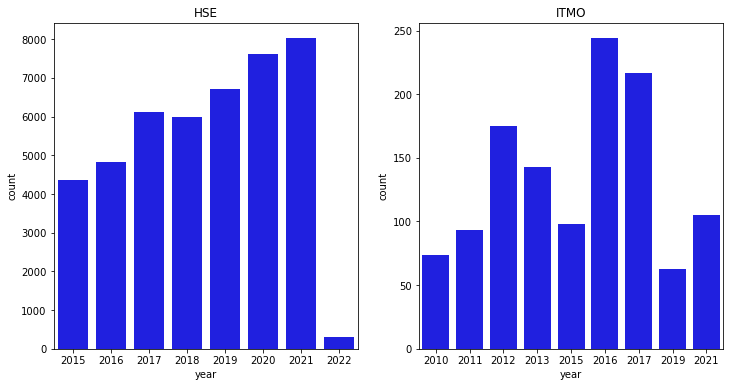

In [22]:
with add_subplots(1, 2, figsize=(12, 6)) as (hse_ax, itmo_ax):
    plot_year_distriubtion(transformed_hse_df, "HSE", hse_ax)
    plot_year_distriubtion(transformed_itmo_df, "ITMO", itmo_ax)

In [23]:
print("HSE programmes:", transformed_hse_df["educational_programme"].nunique())
print("ITMO programmes:", transformed_itmo_df["educational_programme"].nunique())
print()

print("HSE faculties:", transformed_hse_df["faculty"].nunique())
print("ITMO faculties:", transformed_itmo_df["faculty"].nunique())
print()

HSE programmes: 248
ITMO programmes: 139

HSE faculties: 47
ITMO faculties: 56



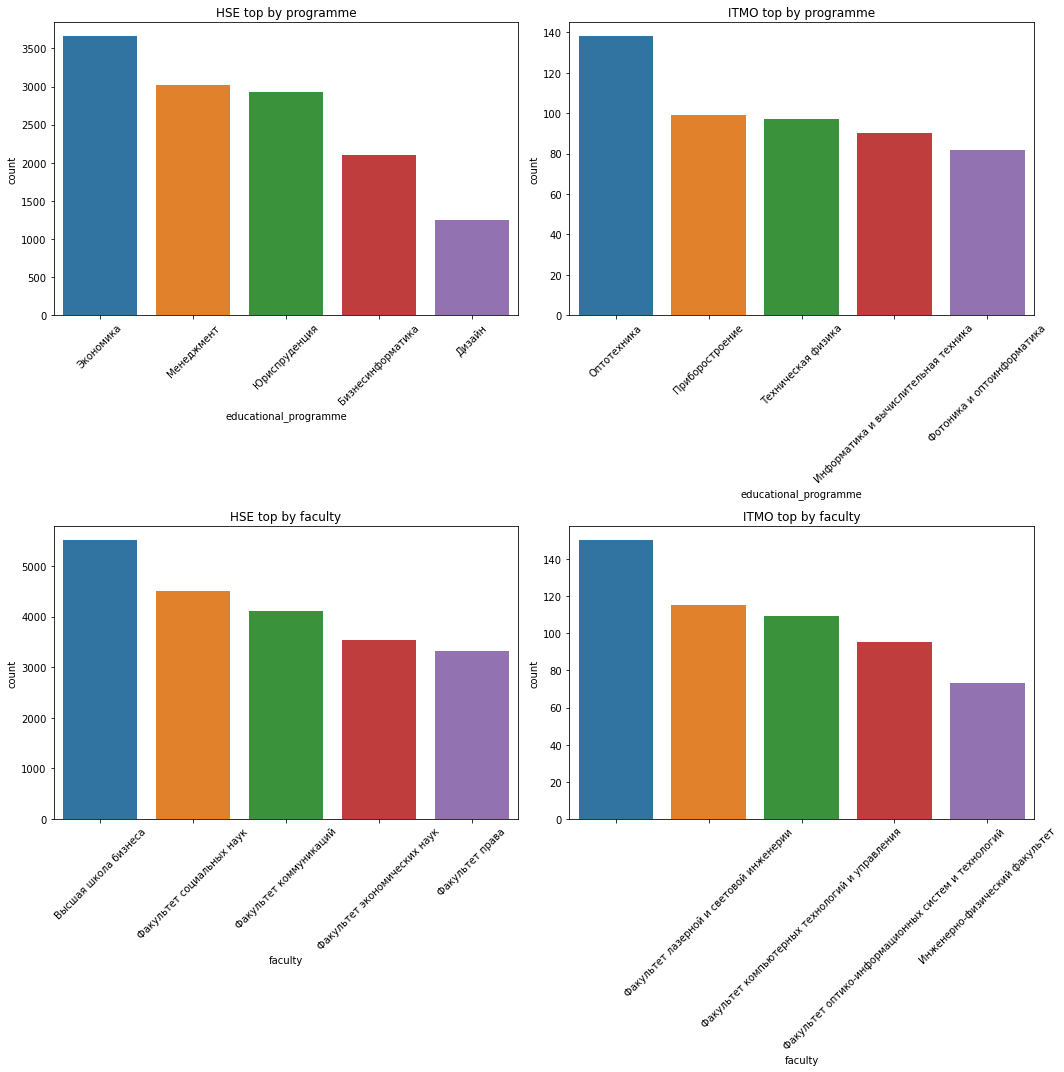

In [24]:
def plot_diplomas_by(df: pd.DataFrame, column: str, title: str, ax, first_n: int = 5):
    groups = df[[column, "title"]].groupby(column, as_index=False).count().rename(columns=rename_title)
    groups = groups.sort_values(by="count", ascending=False)
    top_values = groups[:first_n]

    ax.set_title(title)
    sns.barplot(x=column, y="count", data=top_values, ax=ax)

    for item in ax.get_xticklabels():
        item.set_rotation(45)


with add_subplots(2, 2, figsize=(15, 15)) as ((hse_prog, itmo_prog), (hse_fac, itmo_fac)):
    plot_diplomas_by(transformed_hse_df, column="educational_programme", title="HSE top by programme", ax=hse_prog)
    plot_diplomas_by(transformed_itmo_df, column="educational_programme", title="ITMO top by programme", ax=itmo_prog)
    plot_diplomas_by(transformed_hse_df, column="faculty", title="HSE top by faculty", ax=hse_fac)
    plot_diplomas_by(transformed_itmo_df, column="faculty", title="ITMO top by faculty", ax=itmo_fac)

plt.tight_layout()

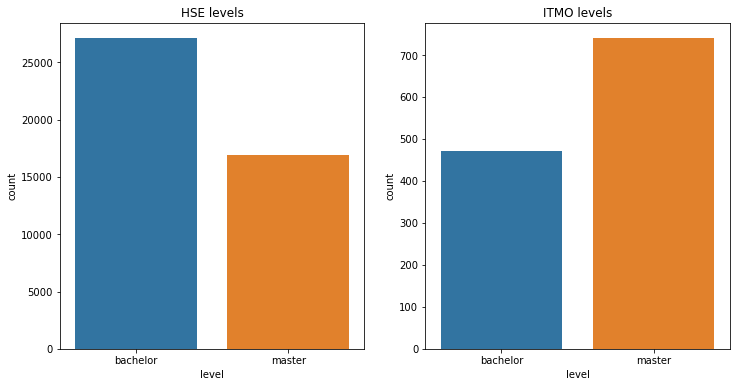

In [25]:
def plot_levels(df: pd.DataFrame, title: str, ax):
    ax.set_title(title)

    groups = df[["level", "title"]].groupby("level", as_index=False).count() \
        .rename(columns=rename_title)
    sns.barplot(x="level", y="count", data=groups, ax=ax)


with add_subplots(1, 2, figsize=(12, 6)) as (hse_ax, itmo_ax):
    plot_levels(transformed_hse_df, "HSE levels", hse_ax)
    plot_levels(transformed_itmo_df, "ITMO levels", itmo_ax)

## plot time progressions

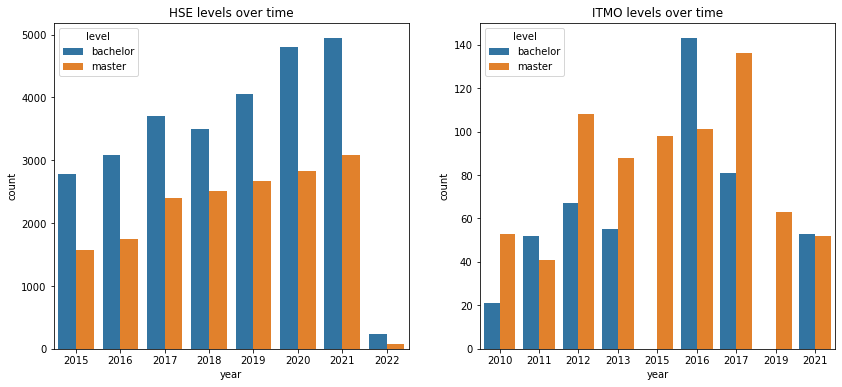

In [26]:
def plot_levels_over_time(df: pd.DataFrame, title: str, ax):
    groups = df[["year", "level", "title"]] \
        .groupby(["year", "level"], as_index=False) \
        .count().rename(columns=rename_title)
    ax.set_title(title)
    sns.barplot(x="year", y="count", hue="level", data=groups, ax=ax)


with add_subplots(1, 2, figsize=(14, 6)) as (hse_ax, itmo_ax):
    plot_levels_over_time(transformed_hse_df, "HSE levels over time", hse_ax)
    plot_levels_over_time(transformed_itmo_df, "ITMO levels over time", itmo_ax)

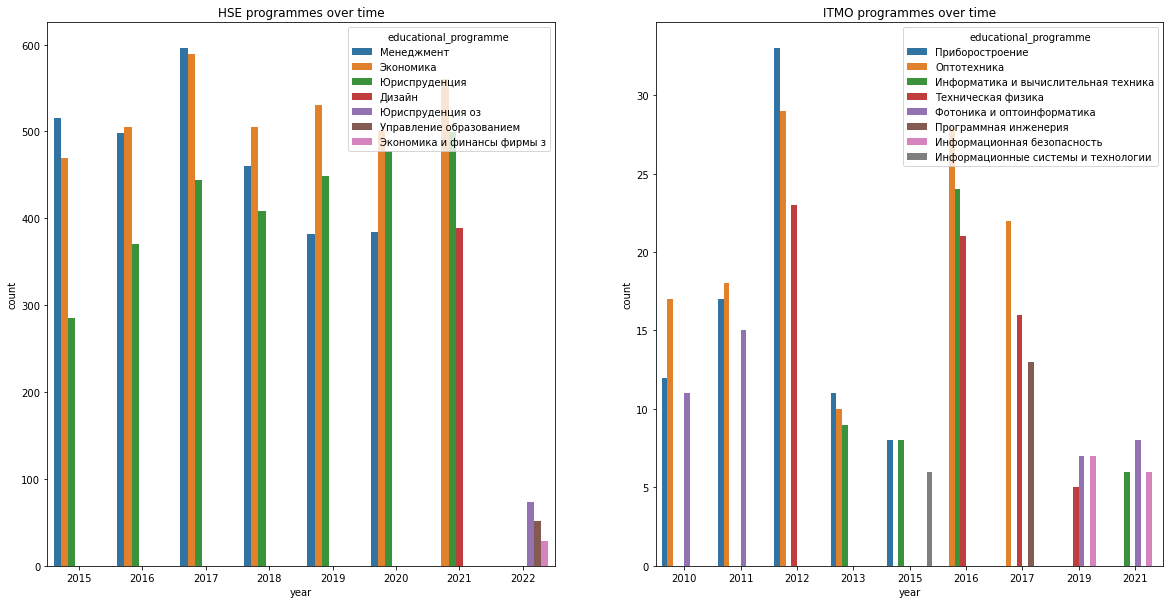

In [27]:
def plot_programmes_over_time(df: pd.DataFrame, title: str, ax, n_year: int = 3):
    groups = df[["year", "educational_programme", "title"]] \
        .groupby(["year", "educational_programme"], as_index=False).count() \
        .sort_values(by="title", ascending=False) \
        .groupby("year", as_index=False) \
        .head(n_year).rename(columns=rename_title)
    ax.set_title(title)
    sns.barplot(x="year", y="count", hue="educational_programme", data=groups, ax=ax)


with add_subplots(1, 2, figsize=(20, 10)) as (hse_ax, itmo_ax):
    plot_programmes_over_time(transformed_hse_df, "HSE programmes over time", hse_ax)
    plot_programmes_over_time(transformed_itmo_df, "ITMO programmes over time", itmo_ax)

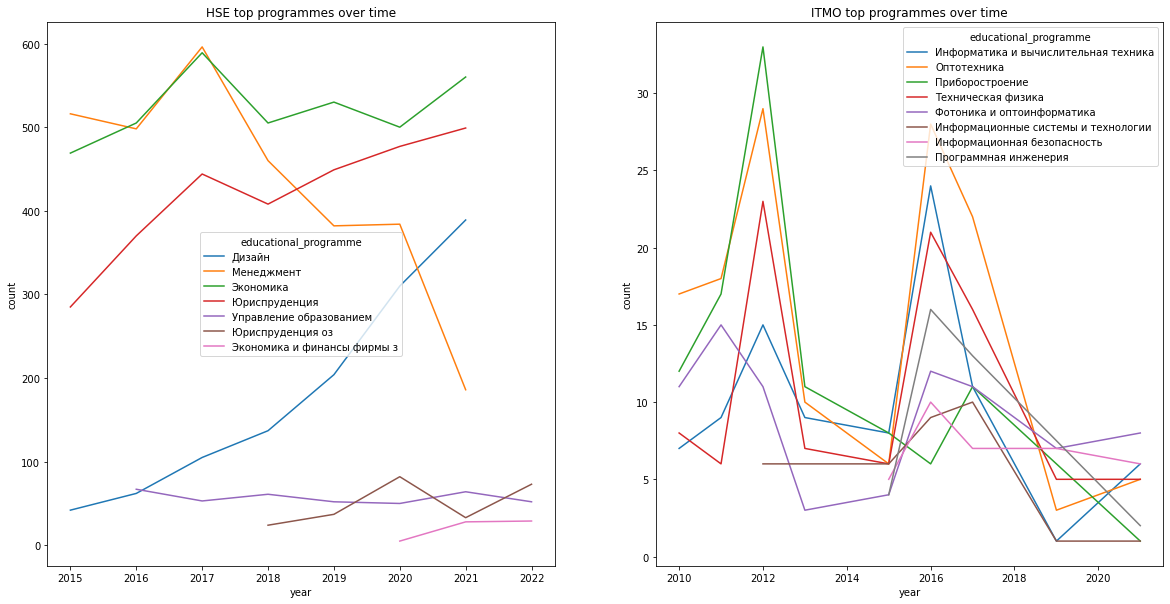

In [28]:
def plot_top_programmes_over_time(df: pd.DataFrame, title: str, ax, n_year: int = 3, n_window: int = 3):
    year_popularity_groups = df[["year", "educational_programme", "title"]] \
        .groupby(["year", "educational_programme"], as_index=False).count()
    year_popularity_groups = year_popularity_groups.sort_values(by="title", ascending=False) \
        .groupby("year").head(n_year)
    most_popular_programmes = year_popularity_groups["educational_programme"].unique()

    groups = df.loc[df["educational_programme"] \
        .isin(most_popular_programmes), ["year", "educational_programme", "title"]] \
        .groupby(["year", "educational_programme"], as_index=False) \
        .count().sort_values("year", ascending=True) \
        .rename(columns=rename_title)
    
    ax.set_title(title)
    sns.lineplot(x="year", y="count", hue="educational_programme", data=groups, ax=ax)


with add_subplots(1, 2, figsize=(20, 10)) as (hse_ax, itmo_ax):
    plot_top_programmes_over_time(transformed_hse_df, "HSE top programmes over time", hse_ax)
    plot_top_programmes_over_time(transformed_itmo_df, "ITMO top programmes over time", itmo_ax)

## count machine learning topics

In [21]:
from functools import partial
import re
from typing import Callable

In [22]:
def count_tokens(text: str, regex: re.Pattern) -> int:
    return len(regex.findall(text))

In [55]:
def test_regex(regex: re.Pattern, matched_texts: list[str], not_matched_texts: list[str]):
    def _upper_lower_text(text: str, upper_indices: list[int], lower_indices: list[str]):
        def _transform_char(index: int) -> str:
            if index in upper_indices:
                return text[index].upper()
            elif index in lower_indices:
                return text[index].lower()
            else:
                return text[index]
        
        return "".join(_transform_char(i) for i in range(len(text)))
    
    def _get_transformed_texts(
        texts: list[str], transforms: list[Callable[[str], str]]
    ) -> list[str]:
        result = []
        for T in transforms:
            result.extend(map(T, texts))
        return result

    text_transforms: list[Callable[[str], str]] = [
        lambda text: text,
        lambda text: text.upper(),
        lambda text: text.lower(),
        lambda text: _upper_lower_text(
            text,
            list(range(len(text) // 2)),
            list(range(len(text) // 2, len(text)))
        ),
        lambda text: _upper_lower_text(
            text,
            list(range(len(text) // 2, len(text))),
            list(range(len(text) // 2))
        )
    ]

    n_cases = 0
    for text in _get_transformed_texts(matched_texts, text_transforms):
        assert count_tokens(text, regex) > 0
        n_cases += 1
    for text in _get_transformed_texts(not_matched_texts, text_transforms):
        assert count_tokens(text, regex) == 0
        n_cases += 1
    print(f"Tested {n_cases} cases")

In [56]:
ml_regexp = re.compile(r"machine\s+learning", flags=re.IGNORECASE)
ml_ru_regexp = re.compile(r"машинн[а-яА-Я]+\s+обучен[а-яА-Я]+", flags=re.IGNORECASE)

test_regex(
    ml_regexp,
    ["asdasd machine \nlearning blalbaslf"],
    ["asdjquwbd1092rhdfcnas safh8129hndfclask"]
)
test_regex(
    ml_ru_regexp,
    [
        "машинное\n\t обучение, всегда бывшее первой задачей",
        "авторы машинного обучения -- сделали выводы"
    ],
    [
        "обучение машин\n\n, фывфыв",
        "машинное контструктивное обучение",
        "машинное\n, обучение которых"
    ]
)

Tested 10 cases
Tested 25 cases


In [57]:
ds_regexp = re.compile(r"data\s+science", flags=re.IGNORECASE)

test_regex(
    ds_regexp,
    ["с развитием data \t\nscience"],
    ["...based on data scientists could find all the answers"]
)

Tested 10 cases


In [58]:
ai_regexp = re.compile(r"artificial\s+intelligence", flags=re.IGNORECASE)
ai_ru_regexp = re.compile(r"искусствен[а-яА-Я]+\s+интеллект[а-яА-Я]*", flags=re.IGNORECASE)

test_regex(
    ai_regexp,
    ["found artificial\n\n\tintelligence amazing..."],
    ["it was artificial, though intelligence could help us"]
)
test_regex(
    ai_ru_regexp,
    ["искусственный интеллект", "искусственного интеллекта"],
    ["искусственный, интеллект которого заставляет задуматься"]
)

Tested 10 cases
Tested 15 cases


In [59]:
ai_short_regexp = re.compile(r"\WAI\W", flags=re.IGNORECASE)
ai_short_ru_regexp = re.compile(r"\WИИ\W", flags=re.IGNORECASE)

test_regex(
    ai_short_regexp,
    ["found new \"AI\" methods working"],
    ["Aids becomes an issue", "baity was very successful!"]
)
test_regex(
    ai_short_ru_regexp,
    ["да, ИИ помогает в разработке"],
    ["не нуждается в объяснении", "привет"]
)

Tested 15 cases
Tested 15 cases


In [60]:
def apply_counters(
    df: pd.DataFrame,
    counters: list[tuple[Callable[[str], int], str]],
    total_count_column: str
) -> pd.DataFrame:
    df_copy = df.copy()
    df_copy[total_count_column] = 0

    for counter_function, new_column in counters:
        df_copy[new_column] = df_copy["abstract"].map(counter_function)
        df_copy[total_count_column] = df_copy[total_count_column] + df_copy[new_column]

    return df_copy

In [61]:
ds_counters = [
    (partial(count_tokens, regex=ml_regexp), "ml"),
    (partial(count_tokens, regex=ml_ru_regexp), "ml_ru"),
    (partial(count_tokens, regex=ds_regexp), "ds"),
    (partial(count_tokens, regex=ai_regexp), "ai"),
    (partial(count_tokens, regex=ai_ru_regexp), "ai_ru"),
    (partial(count_tokens, regex=ai_short_regexp), "ai_short"),
    (partial(count_tokens, regex=ai_short_ru_regexp), "ai_short_ru"),
]
total_count_column = "total_ds_count"

itmo_ds_counts_df = apply_counters(
    transformed_itmo_df,
    counters=ds_counters,
    total_count_column=total_count_column
)
hse_ds_counts_df = apply_counters(
    transformed_hse_df,
    counters=ds_counters,
    total_count_column=total_count_column
)

In [62]:
def describe_ds_counts(df: pd.DataFrame, columns: list[str]):
    for col in columns:
        total_counts = df[col].sum()
        nonzero_rows = (df[col] > 0).sum()
        percent = nonzero_rows / len(df)
        
        print(f"Column = {col}")
        print(f"total occurencies = {total_counts}")
        print(f"nonzero rows = {int(nonzero_rows)} ({percent * 100:.2f}%)")
        print()

In [63]:
ds_freq_columns = [
    col_name for _, col_name in ds_counters
] + ["total_ds_count"]

In [64]:
describe_ds_counts(itmo_ds_counts_df, ds_freq_columns)

Column = ml
total occurencies = 0
nonzero rows = 0 (0.00%)

Column = ml_ru
total occurencies = 114
nonzero rows = 38 (3.14%)

Column = ds
total occurencies = 0
nonzero rows = 0 (0.00%)

Column = ai
total occurencies = 1
nonzero rows = 1 (0.08%)

Column = ai_ru
total occurencies = 47
nonzero rows = 14 (1.16%)

Column = ai_short
total occurencies = 17
nonzero rows = 11 (0.91%)

Column = ai_short_ru
total occurencies = 28
nonzero rows = 15 (1.24%)

Column = total_ds_count
total occurencies = 207
nonzero rows = 68 (5.61%)



In [65]:
describe_ds_counts(hse_ds_counts_df, ds_freq_columns)

Column = ml
total occurencies = 12
nonzero rows = 11 (0.03%)

Column = ml_ru
total occurencies = 1176
nonzero rows = 725 (1.65%)

Column = ds
total occurencies = 10
nonzero rows = 8 (0.02%)

Column = ai
total occurencies = 3
nonzero rows = 3 (0.01%)

Column = ai_ru
total occurencies = 400
nonzero rows = 186 (0.42%)

Column = ai_short
total occurencies = 20
nonzero rows = 15 (0.03%)

Column = ai_short_ru
total occurencies = 170
nonzero rows = 49 (0.11%)

Column = total_ds_count
total occurencies = 1791
nonzero rows = 883 (2.01%)



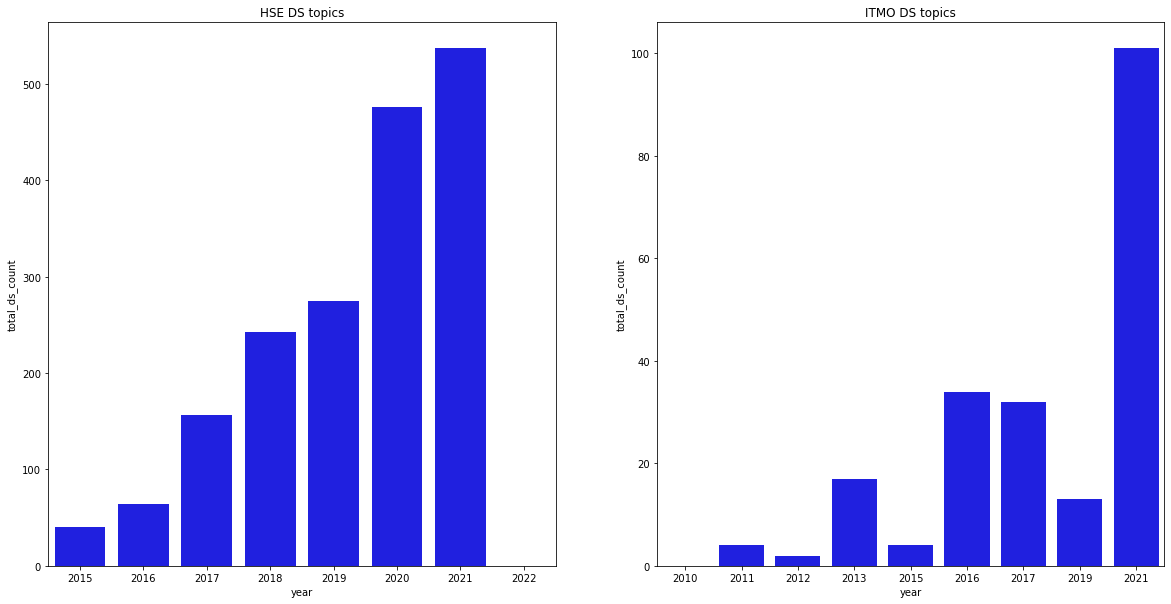

In [69]:
def plot_ds_topics_over_time(df: pd.DataFrame, title: str, ax):
    groups = df[["year", "total_ds_count"]] \
        .groupby(["year"], as_index=False).sum() \
        .sort_values(by="year", ascending=True)
    ax.set_title(title)
    sns.barplot(x="year", y="total_ds_count", data=groups, ax=ax, color="b")


with add_subplots(1, 2, figsize=(20, 10)) as (hse_ax, itmo_ax):
    plot_ds_topics_over_time(hse_ds_counts_df, "HSE DS topics", hse_ax)
    plot_ds_topics_over_time(itmo_ds_counts_df, "ITMO DS topics", itmo_ax)